In [138]:
# read in wrf auxout & lasso files
# compare large scale forcing

# wrf area average

import numpy as np
import pandas as pd
import wrf
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
import xarray as xr
import datetime

# c1
site_latitude  = 36.6050
site_longitude = -97.485

lasso_hres = 16
wrf_hres = 3

target_height_agl = 80

# number of wrf cells in 1 lasso cell, in 1 direction 
# wrf cell span includes the cell of target location
wrf_cell_span = np.floor(lasso_hres/wrf_hres)

# convert an even number to an odd number, round down
# so the total wrf cell span is certainly smaller than a lasso cell
if (wrf_cell_span % 2) == 0:
    wrf_cell_span -= 1

# wrf cell to account for in each direction
wrf_ij_diff = (wrf_cell_span-1)/2

In [168]:
def get_wrf_area_avg_tend(dpath):

    wrf_columns = ['t_tend', 'u_tend', 'v_tend']

    df = pd.DataFrame(columns=wrf_columns)

    for file in glob.glob(dpath+'mmc_d02*')[:2]:
#     for file in glob.glob(dpath+'wrfout_d02*')[:2]:

        wrf_single = Dataset(file,'r')

        site_loc_ij = wrf.ll_to_xy(wrf_single, site_latitude, site_longitude)
        area_start = site_loc_ij.values-wrf_ij_diff
        area_end = site_loc_ij.values+wrf_ij_diff

        wrf_time = wrf.extract_times(wrf_single, timeidx=wrf.ALL_TIMES)
        z_agl  = wrf.getvar(wrf_single, 'height_agl')
        
        t_tend_adv = wrf.getvar(wrf_single, 'T_TEND_ADV', timeidx=wrf.ALL_TIMES)
        mut = wrf.getvar(wrf_single, 'MUT', timeidx=wrf.ALL_TIMES)

        ru_tend = wrf.getvar(wrf_single, 'RU_TEND', timeidx=wrf.ALL_TIMES)
        muu = wrf.getvar(wrf_single, 'MUU', timeidx=wrf.ALL_TIMES)
        
        rv_tend = wrf.getvar(wrf_single, 'RV_TEND', timeidx=wrf.ALL_TIMES)
        muv = wrf.getvar(wrf_single, 'MUV', timeidx=wrf.ALL_TIMES)

        t_tend = t_tend_adv/mut
        u_tend = ru_tend/muu
        v_tend = rv_tend/muv

        levels = np.asarray([target_height_agl])

        df_1file = pd.DataFrame(index=wrf_time, columns=wrf_columns)

        for t_ind, t in enumerate(wrf_time): 

            t_tend_list, u_tend_list, v_tend_list = [], [], []

            for i in range(int(area_start[0]), int(area_end[0]+1)):
                for j in range(int(area_start[1]), int(area_end[1]+1)): 

                    
                    if wrf_time.shape[0] > 1: 
                        t_tend_1pt = t_tend[t_ind, :, i, j]
                        u_tend_1pt = u_tend[t_ind, :, i, j]
                        v_tend_1pt = v_tend[t_ind, :, i, j]
                    else: 
                        t_tend_1pt = t_tend[:, i, j]
                        u_tend_1pt = u_tend[:, i, j]
                        v_tend_1pt = v_tend[:, i, j]
                    
                    z_agl_1pt = z_agl[:, i, j]

                    # tried wrf.vinterp(), can't get it working
                    t_tend_itp = wrf.interp1d(t_tend_1pt, z_agl_1pt, levels)
                    u_tend_itp = wrf.interp1d(u_tend_1pt, z_agl_1pt, levels)
                    v_tend_itp = wrf.interp1d(v_tend_1pt, z_agl_1pt, levels)

                    t_tend_list.append(t_tend_itp.values[0])
                    u_tend_list.append(u_tend_itp.values[0])
                    v_tend_list.append(v_tend_itp.values[0])

            df_1file.loc[t, ['t_tend']] = np.mean(t_tend_list)
            df_1file.loc[t, ['u_tend']] = np.mean(u_tend_list)
            df_1file.loc[t, ['v_tend']] = np.mean(v_tend_list)

        df = df.append(df_1file)

    df.sort_index(inplace=True)
    
    return df

def get_lasso_df_1height(file, year, month, date):

    ds = xr.open_dataset(file)

    for ind, val in enumerate(ds['Times']): 

        ds.Times.values[ind] = ds.Times.values[ind].decode("utf-8")
        ds.Times.values[ind] = datetime.datetime.strptime(ds.Times.values[ind], '%Y-%m-%d_%H:%M:%S')
    #     ds.Times.values[ind] = np.datetime64(ds.Times.values[ind])

    ds = ds.assign_coords({'Time': ds.Times})

    select = ds.sel(Time=slice(datetime.datetime(year, month, date), datetime.datetime(year, month, date+1)))

    subset = select.where(select.Z_LS == target_height_agl, drop=True)
    
    return subset

In [169]:
dpath = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0805m2/auxout/'
wrf_df = get_wrf_area_avg_tend(dpath)
wrf_df

,t_tend,u_tend,v_tend
2018-08-04 12:00:00,NaN,NaN,NaN
2018-08-04 12:10:00,-0.000119,-0.000582,-0.000601
2018-08-04 12:20:00,-0.000083,-0.000122,-0.000301
2018-08-04 12:30:00,-0.000046,-0.000215,0.000537
2018-08-04 12:40:00,0.0,0.000506,-0.000063
2018-08-04 12:50:00,0.000044,0.000399,-0.000018
2018-08-04 14:00:00,-0.000023,0.000675,0.000052


In [ ]:
# 

In [163]:
dpath = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/'
wrf_df = get_wrf_area_avg_tend(dpath)
# wrf_df

KeyError: 'XLAT_V'

In [140]:
lasso_file = '/projects/mmcpnnl/jlee/lasso/0805-3/config/input_ls_forcing.nc'

lasso_df = get_lasso_df_1height(lasso_file, 2018, 8, 5)

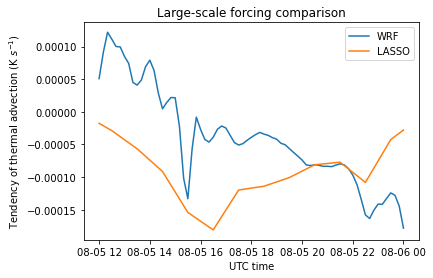

In [143]:
plt.plot(wrf_df, label='WRF')
plt.plot(lasso_df['Time'], lasso_df['TH_ADV'], label='LASSO')

plt.title('Large-scale forcing comparison')
plt.xlabel('UTC time')
plt.ylabel(r'Tendency of thermal advection (K $s^{-1}$)')
plt.legend()
plt.show()

In [128]:
sel0805['Z_LS'][0, :]

<xarray.DataArray 'Z_LS' (force_layers: 751)>
array([    0.,    20.,    40., ..., 14960., 14980., 15000.], dtype=float32)
Coordinates:
    Time     datetime64[ns] 2018-08-05T12:00:00
Dimensions without coordinates: force_layers
Attributes:
    FieldType:    104
    MemoryOrder:  Z  
    description:  height of forcing
    units:        m
    stagger:

In [71]:
df = pd.DataFrame(index=wrf_time, columns=['t_tend'])

In [75]:
df.loc['2018-08-05 12:00:00']

t_tend    NaN
Name: 2018-08-05 12:00:00, dtype: object

## 0805 edmf

## 0901 mynn

## 0901 edmf